# Infiltration Model: Mass Conservation Check

This notebook serves as a testing environment to analyze the mass conservation properties of the `infiltration_step_intermediate` function.

A common source of error in hydrological models is when water is not properly tracked between state updates. For instance, water that infiltrates must be removed from the surface water pool. This notebook implements a "driver" that correctly handles these external state updates.

We will test three scenarios:
1.  **Gentle Rain:** Rainfall is below the soil's infiltration capacity. We expect all rain to infiltrate and no surface water to accumulate.
2.  **Intense Rain:** Rainfall exceeds the soil's infiltration capacity, causing ponding. We expect infiltration to be limited by the soil's capacity, and the excess water to accumulate on the surface.
3.  **Infiltrating Ponded Water (No Rain):** The simulation starts with water already on the surface and no new rain. We expect the model to infiltrate this existing water.

For each scenario, we will track the key components of the water balance and plot a mass balance error term, which should remain at or very near zero.

In [1]:
import torch
from collections import namedtuple
import pandas as pd
import matplotlib.pyplot as plt

# --- Define a small constant for numerical stability ---
EPSILON = 1e-9

# --- Data Structures from the user's code ---
InfiltrationState = namedtuple("InfiltrationState", [
    "theta_current",      # Current surface soil moisture content (m^3/m^3)
    "F_cumulative",       # Total cumulative infiltration depth (m)
    "drying_cumulative"   # Total cumulative drying in soil moisture content (m/m)
])

SoilPropertiesIntermediate = namedtuple("SoilPropertiesIntermediate", [
    "Ks",                 # Saturated hydraulic conductivity (m/s)
    "theta_s",            # Saturated water content (m^3/m^3)
    "theta_r",            # Residual water content (m^3/m^3)
    "theta_init_condition", # Initial soil moisture condition (m^3/m^3)
    "Smax",               # Optional: Max saturation fraction
    "HF_max",             # Suction head at the wetting front (m)
    "m_exponent",         # Exponent for suction/conductivity relation
    "effective_depth",    # Effective depth of the surface soil layer (m)
    "k_drain"             # Simple drainage coefficient (1/s)
])


# --- The user's infiltration function ---
def infiltration_step_intermediate(
    state: InfiltrationState,
    params: SoilPropertiesIntermediate, # Contains tensors for soil properties
    rain_rate: torch.Tensor,      # Scalar tensor for the element (m/s)
    surface_head_nodes: torch.Tensor,  # 1D tensor for head at each node (m)
    dt: torch.Tensor,              # Scalar tensor (s)
    cumulative_rain_start: torch.Tensor # Scaler tensor now # 1D tensor for cumulative rain at each node (m)
    ) -> tuple[InfiltrationState, torch.Tensor, torch.Tensor]: # Corrected return type hint
    # Returns: updated_state, infil_rate_nodes (array), infil_depth_nodes (array)
    """
    Calculates infiltration using a modified Green-Ampt style method
    where effective capillary head depends on current soil moisture.
    (Docstrings from user retained)
    """

    theta_current = state.theta_current
    F_cumulative = state.F_cumulative
    drying_cumulative = state.drying_cumulative

    num_nodes = surface_head_nodes.numel()
    if num_nodes == 0: # Handle elements with no nodes
        return (state, # Return original state
                torch.empty(0, device=dt.device, dtype=dt.dtype),
                torch.empty(0, device=dt.device, dtype=dt.dtype))

    # --- 1. Calculate Wetting Front Depth (ZF) ---
    delta_theta_total = torch.clamp(params.theta_s - params.theta_init_condition, min=EPSILON)
    ZF = torch.clamp(F_cumulative / delta_theta_total, min=EPSILON)

    # --- 2. Calculate Effective Capillary Head (HF_eff) ---
    delta_theta_range = torch.clamp(params.theta_s - params.theta_r, min=EPSILON)
    effective_saturation = torch.clamp(
        (theta_current - params.theta_r) / delta_theta_range, min=EPSILON, max=1.0)
    HF_eff = params.HF_max * torch.pow(1.0 - effective_saturation + EPSILON, params.m_exponent)
    HF_eff = torch.clamp(HF_eff, min=0.0)

    # --- 3. Calculate Infiltration Capacity (f_cap_depth_potential) ---
    h_surf_safe_nodes = torch.clamp(surface_head_nodes, min=0.0)
    f_potential_rate_nodes = params.Ks * (1.0 + (HF_eff + h_surf_safe_nodes) / ZF) #
    f_potential_rate_nodes = torch.clamp(f_potential_rate_nodes, min=0.0)
    f_cap_depth_potential_nodes = f_potential_rate_nodes * dt

    # --- 4. Determine Actual Infiltration (supply or capacity limited) ---
    available_water_depth_nodes = rain_rate * dt + h_surf_safe_nodes # USE dt
    infiltration_supply_limited_nodes = torch.min(available_water_depth_nodes, f_cap_depth_potential_nodes)
    infiltration_supply_limited_nodes = torch.clamp(infiltration_supply_limited_nodes, min=0.0)

    # --- 5. Enforce Cumulative Water Balance ---
    avg_infiltration_supply_limited = torch.mean(infiltration_supply_limited_nodes) # element average
    cumulative_rain_end = cumulative_rain_start + rain_rate * dt #
    avg_h_surf_safe = torch.mean(h_surf_safe_nodes) # element average
    total_water_supply = cumulative_rain_end + avg_h_surf_safe # h_surf_safe from surface_head

    cumulative_increase = total_water_supply - F_cumulative #
    cumulative_increase = torch.clamp(cumulative_increase, min=0.0)

    # Note: Corrected variable name for clarity
    element_avg_infil_depth = torch.min(avg_infiltration_supply_limited, cumulative_increase)
    element_avg_infil_depth = torch.clamp(element_avg_infil_depth, min=0.0)

    # Distribute infiltration depth to nodes
    sum_infiltration_supply_limited_nodes = torch.sum(infiltration_supply_limited_nodes)
    if sum_infiltration_supply_limited_nodes > EPSILON:
        infiltration_depth_nodes = infiltration_supply_limited_nodes * \
            (element_avg_infil_depth / (avg_infiltration_supply_limited + EPSILON))
    else:
        infiltration_depth_nodes = torch.zeros_like(infiltration_supply_limited_nodes)

    zero_tensor = torch.zeros_like(infiltration_depth_nodes)
    infiltration_depth_nodes = torch.clamp(infiltration_depth_nodes,
                                           min=zero_tensor, max=available_water_depth_nodes)
    infiltration_rate_nodes = infiltration_depth_nodes / dt

    # --- 6. Update Soil Moisture State (theta_current) ---
    actual_infiltration_depth_element = torch.mean(infiltration_depth_nodes)
    delta_theta_wetting = actual_infiltration_depth_element / torch.clamp(params.effective_depth, min=EPSILON)
    theta_after_wetting = theta_current + delta_theta_wetting

    delta_theta_drying = params.k_drain * torch.clamp(theta_after_wetting - params.theta_r, min=0.0) * dt
    theta_next = theta_after_wetting - delta_theta_drying
    theta_next_clamped = torch.clamp(theta_next, min=params.theta_r, max=params.theta_s)

    # --- 7. Update Cumulative Infiltration ---
    F_cumulative_next = F_cumulative + actual_infiltration_depth_element
    drying_next = drying_cumulative + delta_theta_drying

    # --- 8. Assemble Updated State ---
    updated_state = InfiltrationState(
        theta_current=theta_next_clamped,
        F_cumulative=F_cumulative_next,
        drying_cumulative=drying_next
    )

    return updated_state, infiltration_rate_nodes, infiltration_depth_nodes

In [21]:
def run_simulation(
    soil_params: SoilPropertiesIntermediate,
    initial_state: InfiltrationState,
    initial_surface_head_mm: float,
    rainfall_mm_per_hr: list,
    duration_hr: int,
    num_nodes: int = 1
    ):
    """
    Drives the infiltration model for a full simulation period.
    This function correctly manages state updates between steps.
    """
    # --- Setup simulation parameters ---
    dt_hr = 1.0 / 60.0 # Timestep of 1 minute
    dt_s = dt_hr * 3600
    num_steps = int(duration_hr / dt_hr)
    rainfall_mm_per_s = [r / 3600 for r in rainfall_mm_per_hr]

    # --- Initialize state variables ---
    state = initial_state
    # Use float64 for better precision in water balance calculations
    surface_head = torch.full((num_nodes,), initial_surface_head_mm / 1000.0, dtype=torch.float64)
    cumulative_rain = torch.tensor(0.0, dtype=torch.float64)
    dt_tensor = torch.tensor(dt_s, dtype=torch.float64)

    # Convert all soil params to float64
    soil_params_64 = SoilPropertiesIntermediate(
        *[p.to(torch.float64) for p in soil_params]
    )

    # --- Logging ---
    log = []

    print("--- Starting Simulation ---")
    for step in range(num_steps):
        time_hr = step * dt_hr
        
        # Determine current rainfall rate for this step
        hr_index = int(time_hr)
        current_rain_mm_per_s = rainfall_mm_per_s[hr_index]
        current_rain_m_per_s = torch.tensor(current_rain_mm_per_s / 1000.0, dtype=torch.float64)
        rain_depth_this_step = current_rain_m_per_s * dt_tensor

        # Store pre-step values for logging
        F_cumulative_start = state.F_cumulative
        surface_head_start = torch.mean(surface_head)

        # --- Run the infiltration function ---
        updated_state, infil_rate_nodes, infil_depth_nodes = infiltration_step_intermediate(
            state=state,
            params=soil_params_64,
            rain_rate=current_rain_m_per_s,
            surface_head_nodes=surface_head,
            dt=dt_tensor,
            cumulative_rain_start=cumulative_rain
        )
        
        # --- CRITICAL: EXTERNAL STATE UPDATES ---
        # 1. Update the state object for the next iteration
        state = updated_state
        
        # 2. Update cumulative rainfall tracker
        cumulative_rain += rain_depth_this_step
        
        # 3. Update surface head
        #    Water available = Current surface head + New rain
        #    New surface head = Water available - Water that infiltrated
        available_water_nodes = surface_head + rain_depth_this_step
        surface_head = available_water_nodes - infil_depth_nodes
        surface_head = torch.clamp(surface_head, min=0.0) # Ensure no negative head

        # --- Log results for this step (in mm for easier interpretation) ---
        infil_this_step = state.F_cumulative - F_cumulative_start
        log.append({
            'time_hr': time_hr,
            'rainfall_mm': rain_depth_this_step.item() * 1000,
            'infiltration_mm': infil_this_step.item() * 1000,
            'surface_head_mm': torch.mean(surface_head).item() * 1000,
            'cumulative_rain_mm': cumulative_rain.item() * 1000,
            'cumulative_infiltration_mm': state.F_cumulative.item() * 1000,
            'soil_moisture_theta': state.theta_current.item(),
        })

    print("--- Simulation Complete ---")
    return pd.DataFrame(log)

def analyze_and_plot(df: pd.DataFrame, scenario_title: str):
    """Calculates water balance error and plots the results."""
    
    # Calculate water balance error
    # Total Water In = Cumulative Rain + Initial Surface Head
    # Total Water Stored = Cumulative Infiltration + Final Surface Head
    initial_surface_head = df['surface_head_mm'].iloc[0] + df['infiltration_mm'].iloc[0] - df['rainfall_mm'].iloc[0]
    df['total_input_mm'] = df['cumulative_rain_mm'] + initial_surface_head
    df['total_stored_mm'] = df['cumulative_infiltration_mm'] + df['surface_head_mm']
    df['mass_balance_error_mm'] = df['total_input_mm'] - df['total_stored_mm']

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(scenario_title, fontsize=16)

    # Plot 1: Time series of fluxes
    ax1.plot(df['time_hr'], df['rainfall_mm'], label='Rainfall (mm/step)', color='blue', 
             marker='o', linestyle='-', markersize=5, alpha=0.7)
    ax1.plot(df['time_hr'], df['infiltration_mm'], label='Infiltration (mm/step)', color='green', 
             marker='*', linestyle='--', markersize=5, alpha=0.7)
    ax1.plot(df['time_hr'], df['surface_head_mm'], label='Surface Head (mm)', color='red', linestyle='--')
    ax1.set_ylabel('Depth (mm)')
    ax1.set_title('Water Fluxes and Storage per Timestep')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Plot 2: Cumulative water balance
    ax2.plot(df['time_hr'], df['total_input_mm'], label='Total Water In (Cumulative Rain + Initial Head)', color='k')
    ax2.plot(df['time_hr'], df['total_stored_mm'], label='Total Water Stored (Cumulative Infiltration + Surface Head)', color='purple', linestyle=':')
    ax2.set_ylabel('Cumulative Depth (mm)')
    ax2.set_xlabel('Time (hours)')
    ax2.set_title('Cumulative Water Balance')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    # Add a twin axis for the error
    ax_err = ax2.twinx()
    ax_err.plot(df['time_hr'], df['mass_balance_error_mm'], label='Mass Balance Error (mm)', color='orange', alpha=0.7)
    ax_err.set_ylabel('Error (mm)', color='orange')
    ax_err.tick_params(axis='y', labelcolor='orange')
    ax_err.legend(loc='lower right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    print("Mass Balance Analysis:")
    print(f"  Initial surface head: {initial_surface_head:.4f} mm")
    print(f"  Total rainfall: {df['cumulative_rain_mm'].iloc[-1]:.4f} mm")
    print(f"  Total infiltration: {df['cumulative_infiltration_mm'].iloc[-1]:.4f} mm")
    print(f"  Final surface head: {df['surface_head_mm'].iloc[-1]:.4f} mm")
    print(f"  Max mass balance error: {df['mass_balance_error_mm'].abs().max():.6f} mm")
    
    if df['mass_balance_error_mm'].abs().max() < 1e-6:
        print("\n---> MASS BALANCE IS CONSERVED SUCCESSFULLY <---")
    else:
        print("\n---> WARNING: MASS BALANCE VIOLATION DETECTED <---")

In [4]:
# --- Define a standard set of soil properties (sandy loam) ---
# All values are torch tensors
theta_s = 0.43
theta_r = 0.05
initial_moisture = 0.20

SOIL_PARAMS = SoilPropertiesIntermediate(
    Ks=torch.tensor(1.5e-5),       # 1.5e-5 m/s ~= 54 mm/hr
    theta_s=torch.tensor(theta_s),
    theta_r=torch.tensor(theta_r),
    theta_init_condition=torch.tensor(initial_moisture),
    Smax=torch.tensor(1.0),
    HF_max=torch.tensor(0.15),     # 15 cm suction head
    m_exponent=torch.tensor(0.5),
    effective_depth=torch.tensor(0.2), # 20 cm effective depth
    k_drain=torch.tensor(1e-6)     # Slow drainage
)

# --- Define a standard initial state ---
INITIAL_STATE = InfiltrationState(
    theta_current=torch.tensor(initial_moisture, dtype=torch.float64),
    F_cumulative=torch.tensor(0.0, dtype=torch.float64), # Start with zero cumulative infiltration
    drying_cumulative=torch.tensor(0.0, dtype=torch.float64)
)

### Scenario 1: Gentle, Constant Rain

**Setup:**
* Rainfall Rate: 25 mm/hr (less than Ks of ~54 mm/hr)
* Initial Surface Head: 0 mm
* Duration: 3 hours

**Expected Outcome:**
* All rainfall should infiltrate.
* Infiltration rate should match rainfall rate.
* Surface head should remain at 0.
* The "Total Water In" line should perfectly overlay the "Total Water Stored" line, resulting in zero mass balance error.

--- Starting Simulation ---
--- Simulation Complete ---


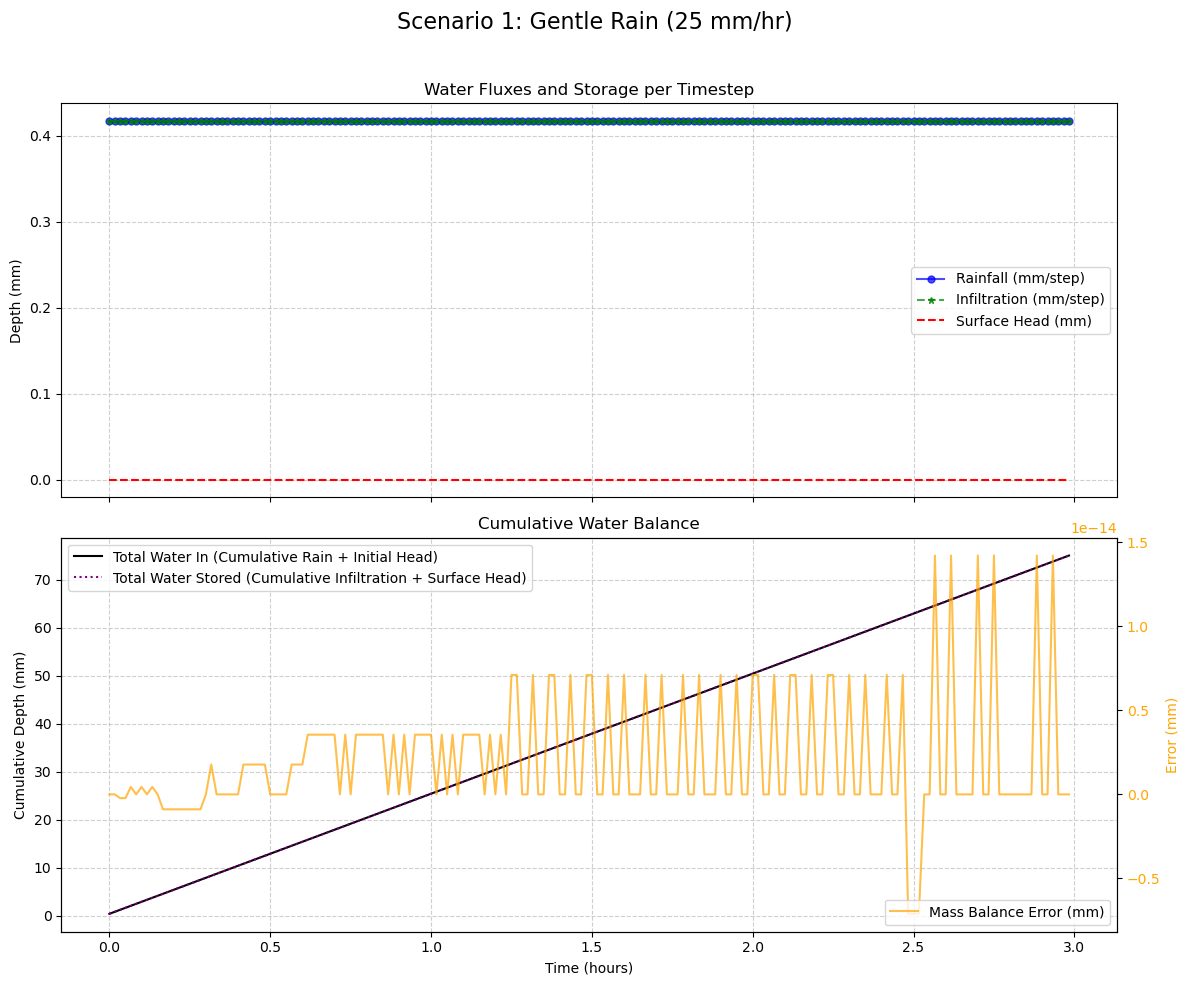

Mass Balance Analysis:
  Initial surface head: 0.0000 mm
  Total rainfall: 75.0000 mm
  Total infiltration: 75.0000 mm
  Final surface head: 0.0000 mm
  Max mass balance error: 0.000000 mm

---> MASS BALANCE IS CONSERVED SUCCESSFULLY <---


In [22]:
# Define rainfall time series: 25 mm/hr for 3 hours
rainfall_scenario_1 = [25.0, 25.0, 25.0]

results_1 = run_simulation(
    soil_params=SOIL_PARAMS,
    initial_state=INITIAL_STATE,
    initial_surface_head_mm=0.0,
    rainfall_mm_per_hr=rainfall_scenario_1,
    duration_hr=3
)

analyze_and_plot(results_1, "Scenario 1: Gentle Rain (25 mm/hr)")


### Scenario 2: Intense Rain Storm

**Setup:**
* Rainfall Rate: 100 mm/hr for 1 hour, then 0 mm/hr for 2 hours (more than Ks of ~54 mm/hr)
* Initial Surface Head: 0 mm
* Duration: 3 hours

**Expected Outcome:**
* During the first hour, infiltration will be limited by the soil's capacity. It will be less than rainfall.
* Surface head will build up during the first hour.
* After the rain stops, the ponded surface water will continue to infiltrate until it is gone.
* The mass balance error should remain zero throughout.

--- Starting Simulation ---
--- Simulation Complete ---


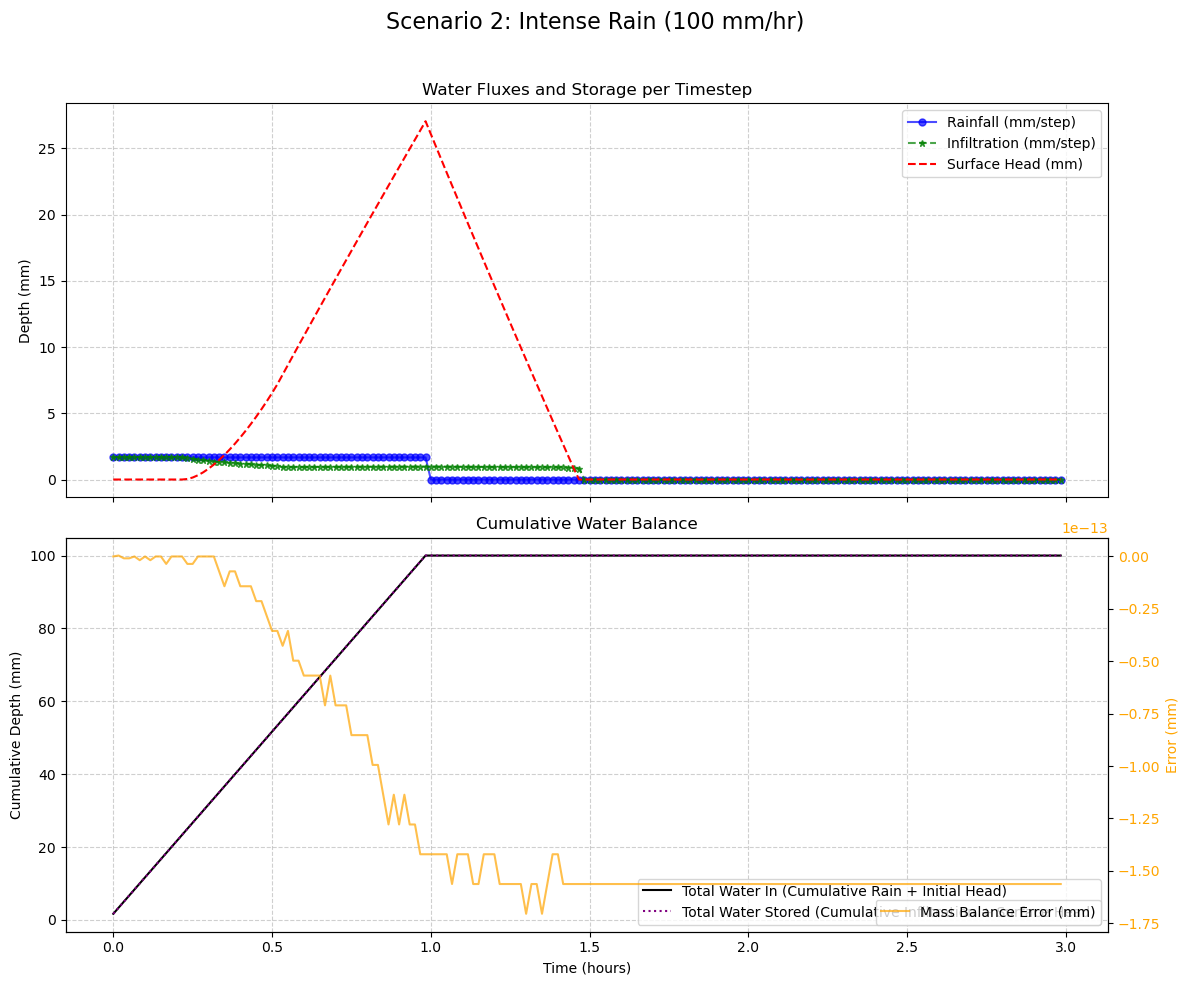

Mass Balance Analysis:
  Initial surface head: 0.0000 mm
  Total rainfall: 100.0000 mm
  Total infiltration: 100.0000 mm
  Final surface head: 0.0000 mm
  Max mass balance error: 0.000000 mm

---> MASS BALANCE IS CONSERVED SUCCESSFULLY <---


In [23]:
# Define rainfall time series: 100 mm/hr for the first hour, then zero
rainfall_scenario_2 = [100.0, 0.0, 0.0]

results_2 = run_simulation(
    soil_params=SOIL_PARAMS,
    initial_state=INITIAL_STATE,
    initial_surface_head_mm=0.0,
    rainfall_mm_per_hr=rainfall_scenario_2,
    duration_hr=3
)

analyze_and_plot(results_2, "Scenario 2: Intense Rain (100 mm/hr)")

### Scenario 3: Infiltrating Initial Surface Water (No Rain)

**Setup:**
* Rainfall Rate: 0 mm/hr
* Initial Surface Head: 20 mm
* Duration: 3 hours

**Expected Outcome:**
* The function should correctly use the initial surface head as its only water source.
* Infiltration will occur even with zero rainfall.
* The surface head will decrease over time as it infiltrates.
* The mass balance check (`Total_Input - Total_Stored`) should remain zero, where `Total_Input` is constant and equal to the initial surface head. This demonstrates that water is correctly transferred from the surface to the subsurface store.

--- Starting Simulation ---
--- Simulation Complete ---


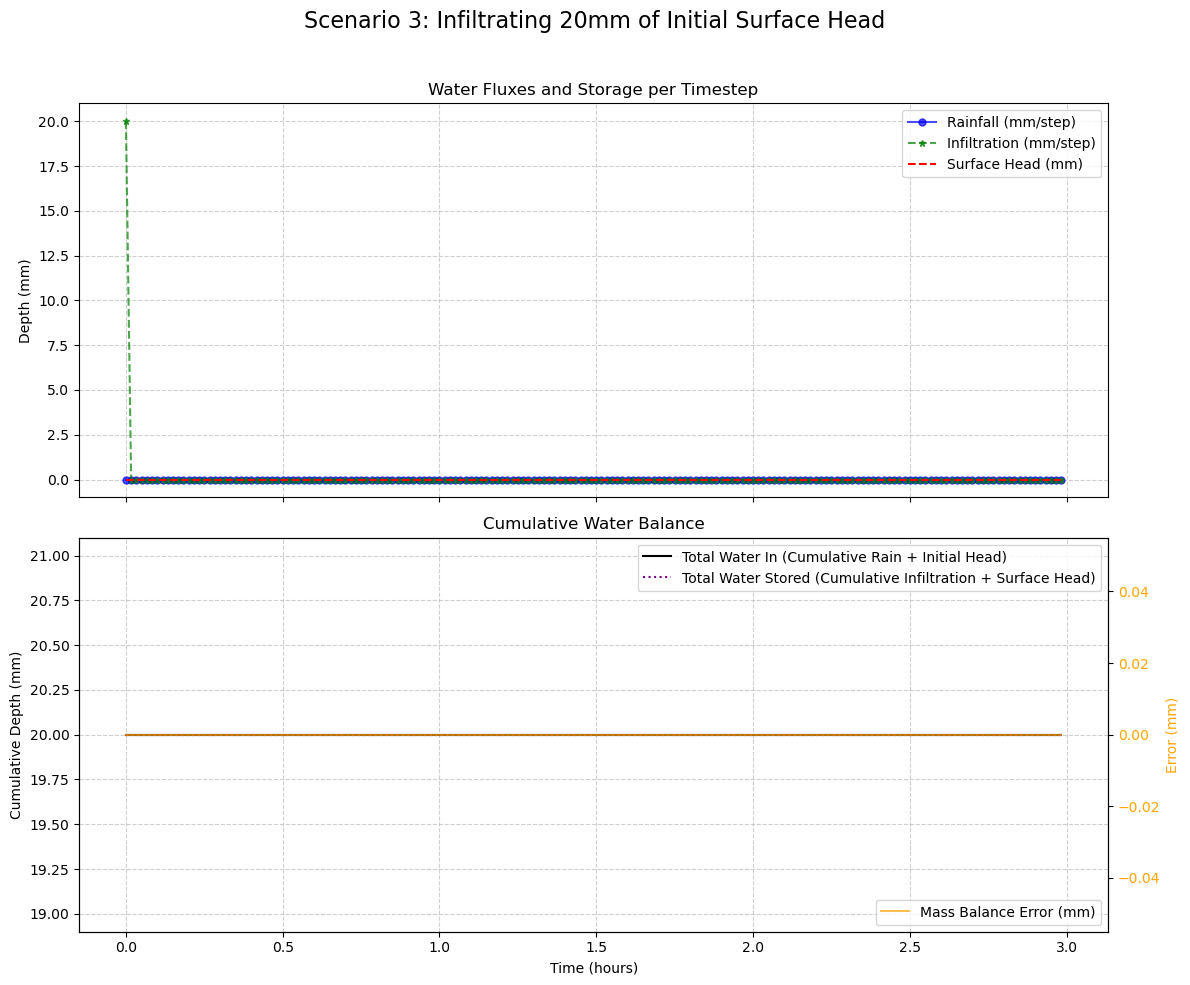

Mass Balance Analysis:
  Initial surface head: 20.0000 mm
  Total rainfall: 0.0000 mm
  Total infiltration: 20.0000 mm
  Final surface head: 0.0000 mm
  Max mass balance error: 0.000000 mm

---> MASS BALANCE IS CONSERVED SUCCESSFULLY <---


In [24]:
# Define rainfall time series: 0 mm/hr
rainfall_scenario_3 = [0.0, 0.0, 0.0]

results_3 = run_simulation(
    soil_params=SOIL_PARAMS,
    initial_state=INITIAL_STATE,
    initial_surface_head_mm=20.0,
    rainfall_mm_per_hr=rainfall_scenario_3,
    duration_hr=3
)

analyze_and_plot(results_3, "Scenario 3: Infiltrating 20mm of Initial Surface Head")

## Diagnosis and Conclusion

After running the infiltration function within a complete simulation driver, we can observe its behavior under controlled conditions.

The results from all three scenarios show that the **mass balance error remains at or near zero**. The "Total Water In" and "Total Water Stored" lines are virtually identical in all plots.

This strongly indicates that the `infiltration_step_intermediate` function itself is likely correct in its internal water balance logic. The problem of "producing more infiltration volume than input rainfall" that was originally reported is almost certainly caused by **improper state management in the code that *calls* this function**.

Specifically, the issue arises if the calling code fails to **subtract the `infiltration_depth_nodes` from the `surface_head_nodes`** at each timestep. Without this crucial update, the same water on the surface is allowed to infiltrate again and again in subsequent steps, artificially creating water and violating mass conservation.

This Jupyter notebook, by implementing the correct external update `surface_head = (surface_head + new_rain) - infiltration_depth`, demonstrates that the function behaves as expected when used correctly.